In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, fc1_unit=None, fc2_unit=None):
        super(NeuralNetwork, self).__init__()
        if fc1_unit is None:
            self.big = False
            self.fc1 = nn.Linear(input_size, 64)
            self.fc2 = nn.Linear(64, output_size)
        else:
            self.big = True
            self.fc1 = nn.Linear(input_size, fc1_unit)
            self.fc2 = nn.Linear(fc1_unit, fc2_unit)
            self.fc3 = nn.Linear(fc2_unit, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))

        if not self.big:
            x = self.fc2(x)
        else:
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
        return x

maze5x5 = [
                ['x', 'x', '#', 'x', 'G'],#0            0
                ['x', 'x', '#', 'x', '.'],#1            ↑
                ['x', '.', '.', '.', '.'],#2         2 ← → 3
                ['.', '.', '#', 'x', 'x'],#3            ↓
                ['S', '.', '#', 'x', 'x'],#4            1
                # 0    1    2    3    4
          ]

maze14x14 = [
                    ['x', '#', 'x', 'x', '.', '.', '.', '.', '#', '#', '#', '#', '.', 'G'],#0
                    ['x', '#', 'x', '#', '#', '#', '.', '.', '.', 'x', 'x', 'x', '.', '.'],#1
                    ['x', 'x', 'x', 'x', '.', '#', '.', '.', '#', 'x', 'x', '#', '.', '.'],#2
                    ['x', '#', '#', '#', '.', '#', '.', '.', '.', 'x', 'x', '#', '.', '.'],#3
                    ['x', 'x', '#', 'x', '.', '#', '#', '#', '#', '#', '.', '#', '#', '.'],#4
                    ['x', 'x', 'x', 'x', '.', '.', '.', 'x', 'x', 'x', '.', '.', '#', '.'],#5
                    ['#', '#', '#', '#', '#', '.', '#', '#', 'x', 'x', '.', '.', '#', '.'],#6
                    ['.', '.', '.', '.', '#', '.', '.', '#', 'x', 'x', '.', '.', '.', '.'],#7
                    ['.', '.', '.', '.', '#', '.', '.', '#', '.', '#', '.', '#', '#', '#'],#8
                    ['#', '.', '#', '.', '#', '.', '#', '#', '.', '#', '.', '.', '.', '.'],#9
                    ['.', '.', '#', '.', '.', '.', '#', '.', '.', '.', '.', '.', '.', '.'],#10
                    ['.', '#', '#', 'x', '#', '.', '.', '.', '.', '#', '.', '#', '#', '.'],#11
                    ['.', 'x', 'x', 'x', '#', '#', '.', '#', '.', '#', '.', '.', '#', '.'],#12
                    ['S', 'x', '#', 'x', '#', '.', '.', '#', '.', '#', '.', '.', '#', '.'],#13
                    # 0    1    2    3    4    5    6    7    8    9   10   11   12   13
                ]

def probMapper(grid, shape, n_models):

    print("Loading models...")
    grid_models = []

    for i in range(n_models):
        if shape == "5x5":
            model = NeuralNetwork(3, 2)
        elif shape == "14x14":
            model = NeuralNetwork(3, 2, 128, 64)

        model.load_state_dict(torch.load("../data/offline_models/{}_{}.pt".format(shape, i)))
        model.eval()

        grid_models.append(model)
    
    print("Models loaded")


    empty_grid = [['' for i in range(len(grid[0]))] for j in range(len(grid))]

    for y in range(len(grid)):
        for x in range(len(grid[y])):
            if grid[y][x] == "#":
                empty_grid[y][x] = "#" 
            else:
                for i in range(4):
                    posibilidades = []

                    test_input = torch.tensor([[float(y), float(x), float(i)]], dtype=torch.float32)
                    
                    for i in range(len(grid_models)):
                        resultado = grid_models[i](test_input)
                        resultado = resultado.detach().numpy()
                        posibilidades.append([round(resultado[0][0]), round(resultado[0][1])])
                    
                    #Calculo el porcentaje de veces que aparece cada posibilidad
                    probability_dict = {str(posibilidades.count(p)/len(posibilidades)*100) + "%": p for p in posibilidades}

                    probability_dict = {}
                    for p in posibilidades:
                        if not str(p) in probability_dict:
                            probability_dict[str(p)] = str(posibilidades.count(p)/len(posibilidades))

                    #Ordeno el diccionario por las probabilidades de mayor a menor
                    probability_dict = {k: v for k, v in sorted(probability_dict.items(), key=lambda item: item[1], reverse=True)}
                    
                    highest_probability = list(probability_dict.keys())[0]

                    #convertirla de nuevo a lista
                    highest_probability = highest_probability.replace("[", "").replace("]", "").split(", ")

                    highest_probability = [highest_probability[0], highest_probability[1]]

                    for p in probability_dict:
                        empty_grid[y][x] = empty_grid[y][x] + str(p) + ": "+ str(round(float(probability_dict[p])*100, 2))+"% "
                        break
                    #print("Probabilidad " + str(p) + ": " + str(posibilidades.count(p)/len(posibilidades)*100) + "%")


    #now I want to plot the grid, each cell containing their string

    binary_grid = np.where(np.array(empty_grid) == '#', 0, 1)
    
    if shape == "5x5":
        plt.figure(figsize=(8, 8))
    elif shape == "14x14":
        plt.figure(figsize=(16, 16))
    # Create a plot
    plt.imshow(binary_grid, cmap='gray', interpolation='nearest')
    # Set the locations of gridlines explicitly to have them at non
    # -even indices
    plt.xticks(np.arange(-0.5, len(binary_grid[0]), 1), [])
    plt.yticks(np.arange(-0.5, len(binary_grid), 1), [])

    plt.grid(True, color='black', linewidth=2, which='both', linestyle='-', alpha=0.5)

    # Draw diagonal lines in each cell to divide it into sectors
    for i in range(len(binary_grid)):
        for j in range(len(binary_grid[0])):

            if binary_grid[i, j] == 1:  # Check if the cell is white
                plt.plot([j - 0.5, j + 0.5], [i - 0.5, i + 0.5], color='black', linewidth=1)
                plt.plot([j + 0.5, j - 0.5], [i - 0.5, i + 0.5], color='black', linewidth=1)

                text = empty_grid[i][j].split("%")
                text1state = text[0].split(":")[0].replace(" ", "")
                text1prob = text[0].split(":")[1] + "%"
                text2state = text[1].split(":")[0].replace(" ", "")
                text2prob = text[1].split(":")[1] + "%"
                text3state = text[2].split(":")[0].replace(" ", "")
                text3prob = text[2].split(":")[1] + "%"
                text4state = text[3].split(":")[0].replace(" ", "")
                text4prob = text[3].split(":")[1] + "%"


                # Add text based on the sector
                if float(text[0].split(":")[1]) > 50.0:
                    color1 = 'green'
                elif float(text[0].split(":")[1]) < 35.0:
                    color1 = 'red'
                else:
                    color1 = 'black'
                if float(text[1].split(":")[1]) > 50.0:
                    color2 = 'green'
                elif float(text[1].split(":")[1]) < 35.0:
                    color2 = 'red'
                else:
                    color2 = 'black'
                if float(text[2].split(":")[1]) > 50.0:
                    color3 = 'green'
                elif float(text[2].split(":")[1]) < 35.0:
                    color3 = 'red'
                else:
                    color3 = 'black'
                if float(text[3].split(":")[1]) > 50.0:
                    color4 = 'green'
                elif float(text[3].split(":")[1]) < 35.0:
                    color4 = 'red'
                else:
                    color4 = 'black'

                plt.text(j, i - .4, text1state, ha='center', va='center', fontsize=6, color=color1)  # North
                plt.text(j, i - .25, text1prob, ha='center', va='center', fontsize=6, color=color1)  # North

                plt.text(j, i + .25, text2prob, ha='center', va='center', fontsize=6, color=color2)  # South
                plt.text(j, i + .4, text2state, ha='center', va='center', fontsize=6, color=color2)  # South

                plt.text(j - .3, i - .1, text3state, ha='center', va='center', fontsize=6, color=color3)  # West
                plt.text(j - .3, i + .05, text3prob, ha='center', va='center', fontsize=6, color=color3)  # West

                plt.text(j + .3, i - .1, text4state, ha='center', va='center', fontsize=6, color=color4)  # East
                plt.text(j + .3, i + .05, text4prob, ha='center', va='center', fontsize=6, color=color4)  # East


    #  Add row numbering on the left from top to bottom
    for i, label in enumerate(range(len(binary_grid))):
        plt.text(-0.8, i, str(label), ha='right', va='center', fontsize=12, color='black')

    # Add column numbering at the bottom
    for j, label in enumerate(range(len(binary_grid[0]))):
        plt.text(j, len(binary_grid) - 0.3, str(label), ha='center', va='top', fontsize=12, color='black')

    # Show the plot
    plt.show()



            

Loading models...
Models loaded


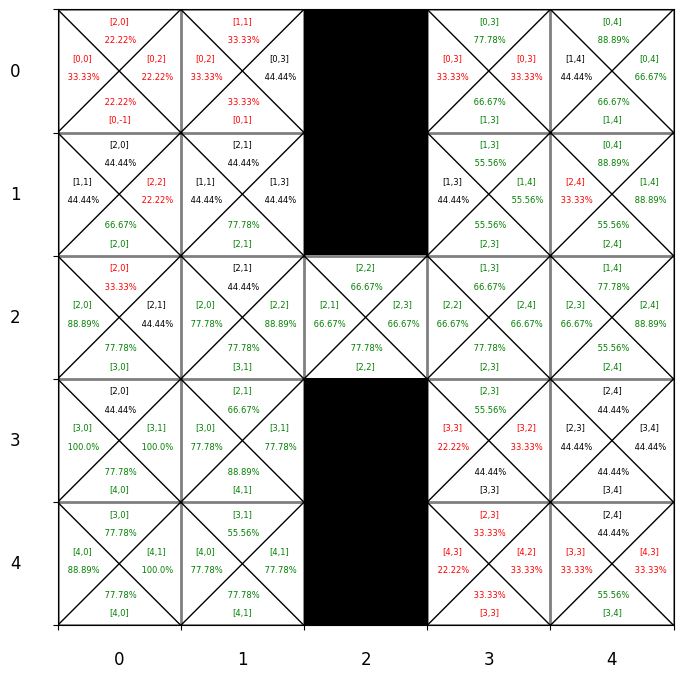

In [6]:
probMapper(maze5x5, "5x5", 9)